In [ ]:
#----------------------------------------------------------------------------

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
import zipfile
import tensorflow as tf
import numpy as np
from keras.preprocessing import image

In [2]:
# Define the file path of the zip file and the directory to extract 
file_path = "archive.zip"
extract_to = "vehicles"

# Check if the zip file exists and extract it
if not os.path.exists(file_path):
    print(f"The provided input file '{file_path}' does not exist. Please check the path.")
else:
    # Extract the contents of the zip file to the specified directory
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        
        # Define directories for training, testing, and validation datasets
    TRAIN_DIR = os.path.join(extract_to, 'train')
    TEST_DIR = os.path.join(extract_to, 'test')
    VAL_DIR = os.path.join(extract_to, 'val')

In [3]:
# Debugging: Print directory contents to verify
def print_directory_contents(directory):
    for root, dirs, files in os.walk(directory):
        print(f"Root: {root}")
        print(f"Directories: {dirs}")
        print(f"Files: {files[:5]}")  # Print only the first 5 files for brevity
        print()

# ImageDataGenerator with rescale to normalize images
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize images to the range [0, 1]
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

training_set = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'  # Use 'categorical' since there are multiple classes
)

val_gen = ImageDataGenerator(rescale=1.0/255.0)  # Normalize validation images to the range [0, 1]

val_ds = val_gen.flow_from_directory(
    VAL_DIR,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'  # Use 'categorical' since there are multiple classes
)

test_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize images to the range [0, 1]
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_set = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'  # Use 'categorical' since there are multiple classes
)

print(f"Found {test_set.samples} images belonging to {test_set.num_classes} classes in test set.")
print(f"Found {training_set.samples} images belonging to {training_set.num_classes} classes in training set.")
print(f"Found {val_ds.samples} images belonging to {val_ds.num_classes} classes in validation set.")


Found 1400 images belonging to 10 classes.
Found 200 images belonging to 10 classes.
Found 200 images belonging to 10 classes.
Found 200 images belonging to 10 classes in test set.
Found 1400 images belonging to 10 classes in training set.
Found 200 images belonging to 10 classes in validation set.


In [4]:
print("Validation Directory Contents:")
print_directory_contents(VAL_DIR)

Validation Directory Contents:
Root: vehicles\val
Directories: ['bus', 'family sedan', 'fire engine', 'heavy truck', 'jeep', 'minibus', 'racing car', 'SUV', 'taxi', 'truck']
Files: []

Root: vehicles\val\bus
Directories: []
Files: ['066c695f141f27ea881df8af5a827c99.jpg', '1b9471eefb6f3951f127beb69ef5a584.jpg', '2b96ccd24db32c2c47581afde8d42722.jpg', '356d8576837338e82cf363d2dc7747c0.jpg', '45242c276cd516adb93561503a2f6ed7.jpg']

Root: vehicles\val\family sedan
Directories: []
Files: ['0cc36cf65da889e22fe9264c3079c459.jpg', '2f180924cbcb4fef31c4eafdd1377a8d.jpg', '383f5f3edc4dd305ba0d1eb57ac55892.jpg', '48dc3c3c0038b87e330d7692cae4b0ff.jpg', '571d8914dd5d1b7e5a493b167ee49ce6.jpg']

Root: vehicles\val\fire engine
Directories: []
Files: ['1570cbe2a81dd646e94bf5e4e3b1f2b1.jpg', '2f313143d05ede99c2458ba697161c1c.jpg', '3f7a8b1ae0bc3d5d82e1240f810ce47d.jpg', '4b8b36da0de861862b49b1886c3c3109.jpg', '4baa8146de477ebafae4b3f46d5614c2.jpg']

Root: vehicles\val\heavy truck
Directories: []
Files: 

In [5]:
print("Test Directory Contents:")
print_directory_contents(TEST_DIR)

Test Directory Contents:
Root: vehicles\test
Directories: ['bus', 'family sedan', 'fire engine', 'heavy truck', 'jeeb', 'minibus', 'racing car', 'SUV', 'taxi', 'truck']
Files: []

Root: vehicles\test\bus
Directories: []
Files: ['066c695f141f27ea881df8af5a827c99.jpg', '1b9471eefb6f3951f127beb69ef5a584.jpg', '2b96ccd24db32c2c47581afde8d42722.jpg', '356d8576837338e82cf363d2dc7747c0.jpg', '45242c276cd516adb93561503a2f6ed7.jpg']

Root: vehicles\test\family sedan
Directories: []
Files: ['0cc36cf65da889e22fe9264c3079c459.jpg', '2f180924cbcb4fef31c4eafdd1377a8d.jpg', '383f5f3edc4dd305ba0d1eb57ac55892.jpg', '48dc3c3c0038b87e330d7692cae4b0ff.jpg', '571d8914dd5d1b7e5a493b167ee49ce6.jpg']

Root: vehicles\test\fire engine
Directories: []
Files: ['1570cbe2a81dd646e94bf5e4e3b1f2b1.jpg', '3f7a8b1ae0bc3d5d82e1240f810ce47d.jpg', '4b8b36da0de861862b49b1886c3c3109.jpg', '4baa8146de477ebafae4b3f46d5614c2.jpg', '4d05406e038cc708cccb6fc4951e8d83.jpg']

Root: vehicles\test\heavy truck
Directories: []
Files: [

In [6]:
# Retrieve the class names from the training set and store them in a list
class_names = list(training_set.class_indices.keys())
print(f"Class names: {class_names}")

Class names: ['SUV', 'bus', 'family sedan', 'fire engine', 'heavy truck', 'jeep', 'minibus', 'racing car', 'taxi', 'truck']


In [7]:
# Retrieve the class names from the validation dataset and store them in a list
class_names = list(val_ds.class_indices.keys())
print(f"Class names: {class_names}")

Class names: ['SUV', 'bus', 'family sedan', 'fire engine', 'heavy truck', 'jeep', 'minibus', 'racing car', 'taxi', 'truck']


In [8]:
def plot_images(x, y, index):
    # Create a figure with a specified size
    plt.figure(figsize=(15, 3))

    # Display the image at the given index from the dataset 'x'
    plt.imshow(x[index])
    
    # Set the label of the x-axis to the class name corresponding to the label of the image
    plt.xlabel(class_names[np.argmax(y[index])])

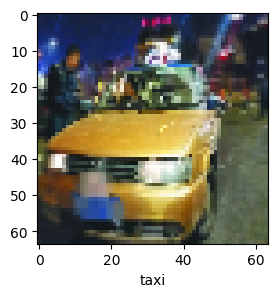

In [9]:
plot_images(training_set[0][0], training_set[0][1], 5)
#training_set[0] returns the first pach of images and labels
#training_set[0][0] returns the first batch of images
#training_set[0][1] returns the first batch of labels
#6 is the index of the image to display
#training_set[0][0][6] is the image
#training_set[0][1][6] is the label

In [10]:
def extract_sift_features(image_paths):
    # Create a SIFT (Scale-Invariant Feature Transform) detector object
    sift = cv2.SIFT_create()
    descriptors_list = []
    
    # Loop through each image path in the provided list
    for img_path in image_paths:

    # Read the image in grayscale mode
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Detect keypoints and compute descriptors for the image
        keypoints, descriptors = sift.detectAndCompute(img, None)

    # If descriptors are found, add them to the list
        if descriptors is not None:
            descriptors_list.append(descriptors)
    return descriptors_list

In [11]:
def create_bag_of_words(descriptors_list, num_clusters=100):
# Create a KMeans clustering object with a specified number of clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    
# Fit the KMeans model to the concatenated list of descriptors
    kmeans.fit(np.vstack(descriptors_list))
    return kmeans

In [12]:
def extract_features_from_bow(descriptors_list, kmeans):
    features = []
    for descriptors in descriptors_list:
# Initialize a histogram with zeros, with the length equal to the number of clusters
        histogram = np.zeros(kmeans.n_clusters)
        if descriptors is not None:
# If descriptors is present, Predict the cluster indices for each descriptor using the trained KMeans model
            cluster_indices = kmeans.predict(descriptors)

# Increment the corresponding histogram bin for each cluster index
            for idx in cluster_indices:
                histogram[idx] += 1

# Append the histogram to the features list
        features.append(histogram)
    return np.array(features)

In [14]:
def get_image_paths_and_labels(directory):
    image_paths = []
    labels = []

# Create a mapping of class labels to numerical indices
    label_map = {label: idx for idx, label in enumerate(os.listdir(directory))}

# Loop through each label (subdirectory) in the given directory
    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)

    # Check if the current path is a directory
        if os.path.isdir(class_dir):

# Loop through each image file in the class directory
            for img_file in os.listdir(class_dir):

         # Construct the full image path
                img_path = os.path.join(class_dir, img_file)

    # Append the image path to the image_paths list
                image_paths.append(img_path)
            
     # Append the corresponding label index to the labels list
                labels.append(label_map[label])

    # Return the lists of image paths and their corresponding labels
    return image_paths, labels

In [15]:
def get_test_image_path(directory):
    # Initialize an empty list to store image paths
    image_paths = []
    
    # Walk through the directory tree rooted at 'directory'
    for root, dirs, files in os.walk(directory):
        # Loop through each file in the current directory
        for file in files:
            # Construct the full image path and append it to the image_paths list
            image_paths.append(os.path.join(root, file))
    
    # Return the list of image paths
    return image_paths

In [16]:
# Example usage:
train_image_paths, train_labels = get_image_paths_and_labels(TRAIN_DIR)
val_image_paths, val_labels = get_image_paths_and_labels(VAL_DIR)
test_image_paths, tesr_labels = get_image_paths_and_labels(TEST_DIR)

In [17]:
print(f"Number of training images: {len(train_image_paths)}")   
print(f"Number of validation images: {len(val_image_paths)}")
print(f"Number of test imags: {len(test_image_paths)}")


Number of training images: 1400
Number of validation images: 200
Number of test imags: 200


In [18]:
train_descriptors_list = extract_sift_features(train_image_paths)
val_descriptors_list = extract_sift_features(val_image_paths)
test_descriptors_list = extract_sift_features(test_image_paths)

# Debugging: Check the size of descriptors list
print(f"Number of training descriptors: {len(train_descriptors_list)}")
print(f"Number of validation descriptors: {len(val_descriptors_list)}")
print(f"Number of test descriptors: {len(test_descriptors_list)}")

Number of training descriptors: 1400
Number of validation descriptors: 200
Number of test descriptors: 200


In [19]:
kmeans = create_bag_of_words(train_descriptors_list, num_clusters=100)
train_features = extract_features_from_bow(train_descriptors_list, kmeans)
val_features = extract_features_from_bow(val_descriptors_list, kmeans)
test_features = extract_features_from_bow(test_descriptors_list, kmeans)

# Debugging: Check the size of features array
print(f"Training features shape: {train_features.shape}")
print(f"Validation features shape: {val_features.shape}")
print(f"Test features shape: {test_features.shape}")

Training features shape: (1400, 100)
Validation features shape: (200, 100)
Test features shape: (200, 100)


In [20]:
from tensorflow.keras import models, layers

# Create a sequential neural network model
ann = models.Sequential([
        # Flatten the input (64x64 RGB images) to a 1D array
        layers.Flatten(input_shape=(64,64,3)),
        
        # Add a dense (fully connected) layer with 3000 units and ReLU activation
        layers.Dense(3000, activation='relu'),
        
        # Add another dense layer with 1000 units and ReLU activation
        layers.Dense(1000, activation='relu'),
        
        # Add the output layer with 10 units (for 10 classes) and softmax activation
        layers.Dense(10, activation='softmax')
    ])

# Compile the model with SGD optimizer, categorical cross-entropy loss, and accuracy metric
ann.compile(optimizer='SGD',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# Train the model on the training set for 5 epochs and validate using the validation set
ann.fit(training_set, epochs=5, validation_data=val_ds)


c:\Users\Work pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5


c:\Users\Work pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 404ms/step - accuracy: 0.1535 - loss: 2.4726 - val_accuracy: 0.3100 - val_loss: 1.9214
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 374ms/step - accuracy: 0.2912 - loss: 2.0254 - val_accuracy: 0.3350 - val_loss: 1.7882
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 359ms/step - accuracy: 0.3322 - loss: 1.8348 - val_accuracy: 0.3400 - val_loss: 1.7776
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.3760 - loss: 1.7737 - val_accuracy: 0.4100 - val_loss: 1.6641
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 366ms/step - accuracy: 0.3610 - loss: 1.7928 - val_accuracy: 0.4400 - val_loss: 1.5658


In [21]:
# Scale the training and validation features using StandardScaler
scaler = StandardScaler().fit(train_features)
train_features = scaler.transform(train_features)
val_features = scaler.transform(val_features)

# Create and train a Support Vector Classifier (SVC)
svc = SVC()
svc.fit(train_features, train_labels)

# Make predictions on the validation set
val_predictions = svc.predict(val_features)

print("Validation Accuracy:", accuracy_score(val_labels, val_predictions))
print("Validation Classification Report:\n", classification_report(val_labels, val_predictions))
print("Validation Confusion Matrix:\n", confusion_matrix(val_labels, val_predictions))

Validation Accuracy: 0.24
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        20
           4       0.31      0.40      0.35        20
           5       0.57      0.20      0.30        20
           6       0.24      0.55      0.33        20
           7       0.59      0.50      0.54        20
           8       0.11      0.40      0.18        20
           9       0.29      0.35      0.32        20

    accuracy                           0.24       200
   macro avg       0.21      0.24      0.20       200
weighted avg       0.21      0.24      0.20       200

Validation Confusion Matrix:
 [[ 0  0  0  1  4  0  4  0  8  3]
 [ 0  0  0  0  3  2  9  0  6  0]
 [ 1  0  0  2  0  1  0  0 12  4]
 [ 0  0  0  0  0  0  3  1 13  3]
 [ 0  1  0  0  8  

c:\Users\Work pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Work pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Work pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [22]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.1, 1],  # Kernel coefficient
    'kernel': ['linear', 'rbf']  # Kernel type
}

# Initialize SVC
svc = SVC()

# Initialize GridSearchCV
grid_search = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(train_features, train_labels)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best estimator (model)
best_svc = grid_search.best_estimator_

# Evaluate the best model on the validation set
val_predictions_best = best_svc.predict(val_features)

print("Validation Accuracy (Best Model):", accuracy_score(val_labels, val_predictions_best))
print("Validation Classification Report (Best Model):\n", classification_report(val_labels, val_predictions_best))
print("Validation Confusion Matrix (Best Model):\n", confusion_matrix(val_labels, val_predictions_best))


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Validation Accuracy (Best Model): 0.45
Validation Classification Report (Best Model):
               precision    recall  f1-score   support

           0       0.32      0.30      0.31        20
           1       0.40      0.50      0.44        20
           2       0.45      0.45      0.45        20
           3       0.45      0.45      0.45        20
           4       0.59      0.50      0.54        20
           5       0.27      0.20      0.23        20
           6       0.57      0.60      0.59        20
           7       0.59      0.65      0.62        20
           8       0.38      0.40      0.39        20
           9       0.45      0.45      0.45        20

    accuracy                           0.45       200
   macro avg       0.45      0.45      0.45       200
weighted avg       0.45      0.45      0.45       200

Validation Confusion Matrix (B

In [23]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3,
activation='relu', input_shape=[64, 64, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3,
activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=10, activation='softmax'))


c:\Users\Work pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
# Compile the CNN model with Adam optimizer, binary cross-entropy loss, and accuracy as a metric
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the training set for 5 epochs and validate using the validation set
history = cnn.fit(x=training_set, validation_data=val_ds, epochs=5)

Epoch 1/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 328ms/step - accuracy: 0.1102 - loss: 0.3655 - val_accuracy: 0.2850 - val_loss: 0.3043
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 309ms/step - accuracy: 0.3465 - loss: 0.2880 - val_accuracy: 0.4250 - val_loss: 0.2430
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 320ms/step - accuracy: 0.4830 - loss: 0.2367 - val_accuracy: 0.5200 - val_loss: 0.2319
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 328ms/step - accuracy: 0.5539 - loss: 0.2123 - val_accuracy: 0.5850 - val_loss: 0.2118
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 321ms/step - accuracy: 0.5841 - loss: 0.2005 - val_accuracy: 0.6050 - val_loss: 0.1917


In [25]:
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,443,136 (9.32 MB)

 Trainable params: 814,378 (3.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,628,758 (6.21 MB)

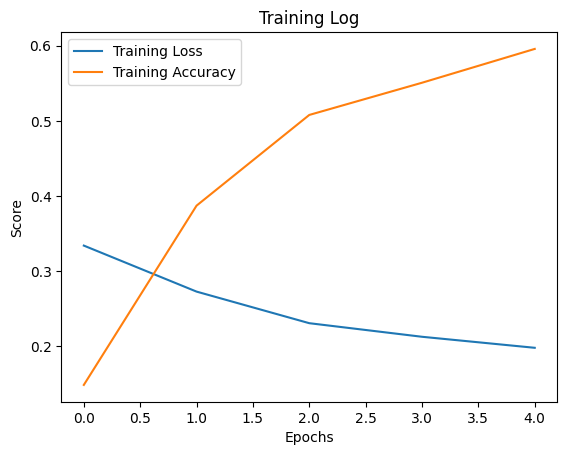

In [26]:
plt.title('Training Log')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

In [27]:
# Compile the CNN model with Adam optimizer, binary cross-entropy loss, and accuracy as a metric
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the training set for 5 epochs and validate using the test set
history = cnn.fit(x=training_set, validation_data=test_set, epochs=5)

Epoch 1/5
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.6151 - loss: 0.1957

c:\Users\Work pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 366ms/step - accuracy: 0.6151 - loss: 0.1957 - val_accuracy: 0.5750 - val_loss: 0.2006
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 325ms/step - accuracy: 0.6639 - loss: 0.1741 - val_accuracy: 0.6150 - val_loss: 0.1948
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 322ms/step - accuracy: 0.7017 - loss: 0.1622 - val_accuracy: 0.6050 - val_loss: 0.1951
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 334ms/step - accuracy: 0.7180 - loss: 0.1530 - val_accuracy: 0.6150 - val_loss: 0.1890
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 338ms/step - accuracy: 0.7298 - loss: 0.1510 - val_accuracy: 0.6350 - val_loss: 0.1813


In [29]:
# Evaluate the model on the test set
test_loss, test_accuracy = cnn.evaluate(test_set)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - accuracy: 0.6795 - loss: 0.1746
Test Loss: 0.18408456444740295
Test Accuracy: 0.6449999809265137


In [28]:
# Retrieve the third image from the first batch of the test set
test_image = test_set[4][0][2]

# Convert the image to a NumPy array
test_image = image.img_to_array(test_image)

# Expand the dimensions of the image to match the input shape expected by the model (batch size, height, width, channels)
test_image = np.expand_dims(test_image, axis=0)

# Use the CNN model to make a prediction on the processed test image
result = cnn.predict(test_image)

# Print the prediction result
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
[[9.0704337e-03 1.2061095e-01 5.8754506e-03 4.9712742e-03 4.7148541e-03
  1.5625614e-03 3.3603823e-01 2.5098259e-04 3.0685835e-02 4.8621944e-01]]


In [30]:
val_accuracy_svc = accuracy_score(val_labels, val_predictions_best)
print("Validation Accuracy (Best SVC Model):", val_accuracy_svc)
print("Validation Classification Report (Best SVC Model):\n", classification_report(val_labels, val_predictions_best))
print("Validation Confusion Matrix (Best SVC Model):\n", confusion_matrix(val_labels, val_predictions_best))


Validation Accuracy (Best SVC Model): 0.45
Validation Classification Report (Best SVC Model):
               precision    recall  f1-score   support

           0       0.32      0.30      0.31        20
           1       0.40      0.50      0.44        20
           2       0.45      0.45      0.45        20
           3       0.45      0.45      0.45        20
           4       0.59      0.50      0.54        20
           5       0.27      0.20      0.23        20
           6       0.57      0.60      0.59        20
           7       0.59      0.65      0.62        20
           8       0.38      0.40      0.39        20
           9       0.45      0.45      0.45        20

    accuracy                           0.45       200
   macro avg       0.45      0.45      0.45       200
weighted avg       0.45      0.45      0.45       200

Validation Confusion Matrix (Best SVC Model):
 [[ 6  3  0  1  2  2  0  0  3  3]
 [ 1 10  1  0  0  4  1  1  2  0]
 [ 2  0  9  3  0  1  0  0  2  3]


In [31]:
test_loss, test_accuracy = cnn.evaluate(test_set)
print("Test Loss (CNN):", test_loss)
print("Test Accuracy (CNN):", test_accuracy)

# Assuming validation accuracy was stored during training
val_accuracy_cnn = max(history.history['val_accuracy'])
print("Validation Accuracy (CNN):", val_accuracy_cnn)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.6298 - loss: 0.1805
Test Loss (CNN): 0.18178114295005798
Test Accuracy (CNN): 0.6399999856948853
Validation Accuracy (CNN): 0.6349999904632568


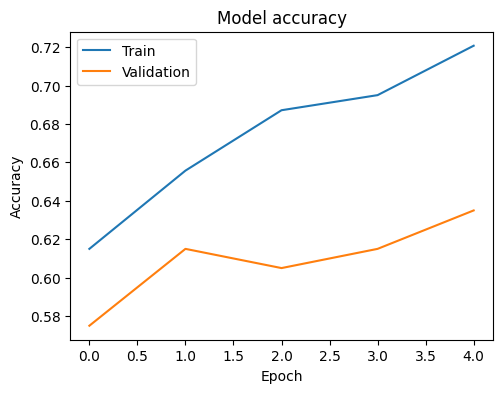

In [32]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')



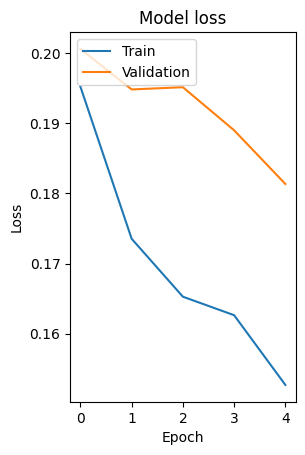

In [33]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


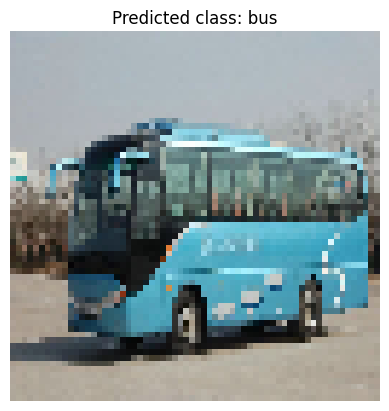

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Define a function to preprocess and predict the class of a single image
def predict_single_image(model, img_path, class_names):
    # Load the image
    img = image.load_img(img_path, target_size=(64, 64))
    
    # Convert the image to an array and add batch dimension
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Normalize the image (as done during training)
    img_array /= 255.0
    
    # Make a prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    
    # Display the image and the predicted class
    plt.imshow(img)
    plt.title(f"Predicted class: {class_names[predicted_class[0]]}")
    plt.axis('off')
    plt.show()

# Example usage:
test_image_path = test_image_paths[0]  # Get the path of the first test image
predict_single_image(cnn, test_image_path, class_names)


2. Analyzing Strengths and Weaknesses

Let's analyze the strengths and weaknesses of each method.
SVC with Bag-of-Words

Strengths:

    Interpretable Features: The bag-of-words model makes it simple to interpret features.
    Efficiency: For smaller datasets, SVC model training can be computationally efficient.
    Less Data Requirement: SVC and SIFT features can function well with smaller datasets as well.

Weaknesses:

    Feature Extraction Complexity: It can be difficult and time-consuming to extract SIFT features and build the bag-of-words model.
    Performance Limitations: If the image dataset is complex, the accuracy might be less than that of CNNs.
    Scalability: If the dataset is bigger or the images are more complicated, the model might not scale well.

CNN

Strengths:

    High Accuracy: CNNs can learn complex features, which allows them to achieve higher accuracy on average.
    End-to-End Learning: CNNs can extract features automatically from raw images, eliminating the need for manual feature extraction.
    Scalability: CNNs are efficient at handling larger datasets and more complicated images.
    
Weaknesses:

    Computationally Intensive: A large amount of computer power, including GPUs, is needed to train CNNs.
    Data Requirement: CNNs often require large amounts of labeled data to achieve good performance.
    Hyperparameter Tuning: CNN architecture design and modifying can be difficult and require knowledge.

3. Identifying Scenarios for Hybrid Approach

A hybrid approach might combine the strengths of both methods:

    Small to Medium-Sized Datasets: Use SIFT + SVC for smaller datasets where computational resources are limited, but accuracy is not the main issue.
    Feature Interpretability: When interpretability of features is important, such as in some research applications or regulatory environments.
    Preprocessing: Using SIFT features as an additional input to CNNs can sometimes improve performance, especially if the SIFT features capture important aspects not easily learned by the CNN.